In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from dataset import Dataset

class HingeLoss(nn.Module):
    def __init__(self,margin = 1):
        super(HingeLoss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        #loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        loss = torch.max(torch.tensor(0.), self.margin - inputs * targets)
        return loss.mean()

In [7]:
class NonStandard(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size, margin = 1):
        super(NonStandard, self).__init__()
        self.ort_base = None
        self.lr = 1e-3
        # self.loss = HingeLoss(margin)
        self.loss = torch.nn.BCEWithLogitsLoss()
        
        self.W1 = torch.nn.Linear(input_size, hidden_size) 
        self.Wmid = torch.nn.Linear(hidden_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.optimizer = torch.optim.SGD(self.parameters(), lr = self.lr)
        N = 2
        self.a = [1/N for i in range(N)]
# --------------------------------------------

    def forward(self, x):
        k = self.W1(x)
        z = F.relu(k)
        j = self.Wmid(z)
        x = F.relu(j)
        y = self.W2(z)
        
        return y
        
    def train(self, dl):
        class_1 = 1
        class_0 = 0

        for x,y in dl:
            y_pred_1 = self(x[y == class_1])
            y_target_1 = y.unsqueeze(1)[y.unsqueeze(1) == class_1]
            y_pred_1[y_pred_1 >= 0.99] = 1

            # Faccio un passo di L1
            self.optimizer.zero_grad()
            eL1 = self.loss(y_pred_1.view(-1), y_target_1)
            eL1.backward()
            self.optimizer.step()
            
            self.optimizer.zero_grad()

            # Vedo quanto sarebbe il gradiente di L1 ora
            y_pred_1 = self(x[y == class_1])
            y_target_1 = y.unsqueeze(1)[y.unsqueeze(1) == class_1]
            # y_pred_1[y_pred_1 >= 0.99] = 1

            y_pred_2 = self(x[y == class_0])
            y_target_2 = y.unsqueeze(1)[y.unsqueeze(1) == class_0]
            # y_pred_2[y_pred_2 >= 0.99] = 1
            
            eL1 = self.loss(y_pred_1.view(-1), y_target_1)

            eL1.backward(retain_graph = True)
            
            saved_grad = []

            # Salvo il gradiente di L1
            for p in self.parameters():
                if p.grad is None:
                    saved_grad.append(None)
                    continue
                saved_grad.append(p.grad.clone().detach())
            
            # I want param.grad to contain only one gradient
            self.optimizer.zero_grad()

            eL2 = self.loss(y_pred_2.view(-1), y_target_2)

            eL2.backward()
            
            # Il gradiente su L1 viene applicato, il gradiente su L2 viene sommato in base a quanto e' il modulo di L1
            for p_saved, p_new in zip(saved_grad, self.parameters()):
                if p_new.grad is None:
                    continue
                # Il Bias lascio quello di L1
                if len(p_new.shape) == 1:
                    p_new.grad = p_saved.norm() * p_new.grad
                else:
                    p_new.grad = self._scale(p_saved, p_new.grad)

            self.optimizer.step()

        return eL1.detach().numpy(), eL2.detach().numpy()

    def _scale(self, L1, L2):

        scale = torch.zeros_like(L1)

        for i in range(L1.shape[0]):
            L1_val = L1[i].norm()
            L2_val = L2[i].norm()
            
            alpha = 1
            beta = 1
            gamma = L1_val
            
            if L1_val > alpha:
                # Se il gradiente su L1 e' maggiore di uno, praticamente ignoro il gradiente di L2
                scale_factor = 1 / gamma
            else:
                # Se il gradiente di L1 e' minore di uno, controllo il gradiente di L2
                if L2_val > beta and L2_val < L1_val:
                    # Se il gradiente di L2 e' minore di uno, il confine e' stato tracciato, non addestro su L2
                    scale_factor = gamma
                else:
                    # L2 non e' ancora vicino al confine, posso dargli due bottarelle
                    scale_factor = 0

            scale[i] = L2[i] * scale_factor

        return scale


In [8]:
torch.manual_seed(1306)
modello = NonStandard(2, 1, 512)
ds = Dataset(8)
dl = ds.get_dataloader()

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


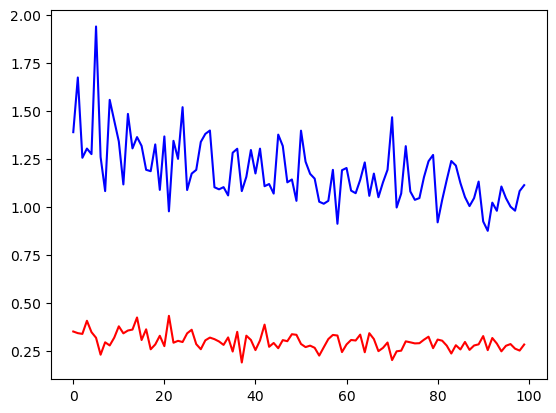

In [9]:
e = 1
err1 = []
err2 = []

# while e > 1e-4:
for i in tqdm(range(100)):
    e1, e2 = modello.train(dl) # Dentro dl ci deveno essere solo y == 1, ed usiamo BCEWithLogitsLoss
    err1.append(e1) 
    err2.append(e2)

plt.plot([x for x in range(len(err1))], err1, label = "Loss1", c = 'red')
plt.plot([x for x in range(len(err2))], err2, label = "Loss2", c = 'blue')
plt.show()

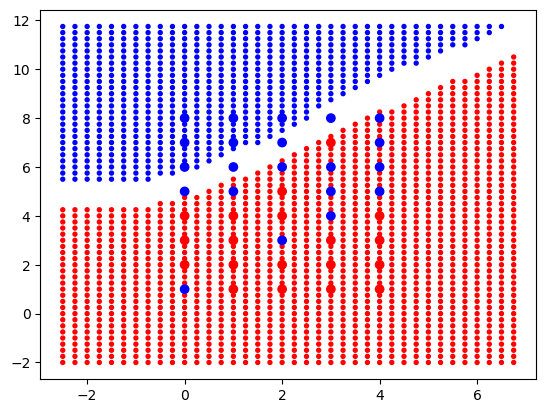

In [10]:
#PLOT FASE 2
dataset = ds.dataset
labels = ds.labels

with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-10,7*4) for y in range(-8,12*4)]
    colori = ['blue' if p[2][0] <= 0.4 else 'red' if p[2][0] >= 0.6 else 'white' for p in points]
    plt.scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
    plt.scatter([p[0] for p in dataset],[p[1] for p in dataset], c=['red' if i == 1 else 'blue' for i in labels])
    plt.show()

# RED -> y == 1 [NON DEVE ENTRARE]
# BLUE -> y == 0 [PUO ENTRARE]
# WHITE -> indecisione